# Stage 2.5 Analysis: Baseline vs Elementwise (1500 iters, wd=1450, lr=0.00468)

In [ ]:
%%bash
source /workspace/ese-3060-project/.venv/bin/activate
python -m ipykernel install --user --name ese3060-venv --display-name "ese3060 venv"
echo "Kernel installed."

In [2]:
from pathlib import Path
import os, glob, re
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%cd /workspace/ese-3060-project

# Detect project root: prefer PROJ_ROOT env, else repo root (parent if running from notebooks/)
cwd = Path.cwd().expanduser().resolve()
default_root = cwd.parent if cwd.name == 'notebooks' else cwd
PROJ_ROOT = Path(os.environ.get('PROJ_ROOT', default_root)).expanduser().resolve()
RESULTS = PROJ_ROOT / 'experiments' / 'results_stage2_5.csv'
RESULTS_ALL = PROJ_ROOT / 'experiments' / 'results.csv'
CURVES_CSV = PROJ_ROOT / 'experiments' / 'log_curves_stage2_5.csv'
LOG_DIR = PROJ_ROOT / 'logs'

# If stage-specific results not found, try to locate under cwd tree
if not RESULTS.exists():
    candidates = list(Path.cwd().rglob('experiments/results_stage2_5.csv'))
    if candidates:
        RESULTS = candidates[0].resolve()
        PROJ_ROOT = RESULTS.parent.parent
        LOG_DIR = PROJ_ROOT / 'logs'
        CURVES_CSV = PROJ_ROOT / 'experiments' / 'log_curves_stage2_5.csv'
    elif RESULTS_ALL.exists():
        RESULTS = RESULTS_ALL

print('Project root:', PROJ_ROOT)
print('Results:', RESULTS)
print('Log dir:', LOG_DIR)
print('Curves CSV:', CURVES_CSV)


[Errno 2] No such file or directory: '/workspace/ese-3060-project'
/home/milos/dev/ese-3060-project/notebooks
Project root: /home/milos/dev/ese-3060-project
Results: /home/milos/dev/ese-3060-project/experiments/results.csv
Log dir: /home/milos/dev/ese-3060-project/logs
Curves CSV: /home/milos/dev/ese-3060-project/experiments/log_curves_stage2_5.csv


In [3]:
# Load results (prefer stage2_5 split; fall back to aggregated filtered for stage2.5 params)
if RESULTS.exists():
    df = pd.read_csv(RESULTS)
elif RESULTS_ALL.exists():
    df = pd.read_csv(RESULTS_ALL)
    # best-effort filter for stage2.5 runs
    df = df[(df.get('num_iterations', 0)==1500) & (df.get('warmdown_iters', 0)==1450) & (df.get('learning_rate', 0).round(5)==0.00468)]
else:
    df = pd.DataFrame()
df.head() if not df.empty else df

,run_id,date,git_commit,seed,attn_gate,gate_pos,gate_act,learning_rate,batch_size,device_batch_size,...,num_iterations,warmdown_iters,final_val_loss,best_val_loss,train_time_ms,ms_per_step,gpu_name,n_gpus,runpod_instance,notes
0,98e5c27a-7c22-4f8f-8002-5ec95c986d6b,2025-12-08 03:24:55,c357df511c00be06ac81976d70129bbee5b60c5d,1337,none,sdpa,sigmoid,0.00468,512,64,...,1500,1450,3.527592,3.527592,597867.552042,400.984274,NVIDIA A100 80GB PCIe,8,unknown,NaN
1,d8ccd85e-ab0b-4251-bda0-b00f25577e14,2025-12-08 03:37:44,c357df511c00be06ac81976d70129bbee5b60c5d,2337,none,sdpa,sigmoid,0.00468,512,64,...,1500,1450,3.532024,3.532024,595719.169378,399.543373,NVIDIA A100 80GB PCIe,8,unknown,NaN
2,61a24362-b17b-4040-b290-3235f22e4f07,2025-12-08 03:52:02,c357df511c00be06ac81976d70129bbee5b60c5d,1337,elementwise,sdpa,sigmoid,0.00468,512,64,...,1500,1450,3.509102,3.509102,631295.059681,423.403796,NVIDIA A100 80GB PCIe,8,unknown,NaN
3,18bee9bc-ccd7-4c34-a4a6-14e945769171,2025-12-08 04:05:20,c357df511c00be06ac81976d70129bbee5b60c5d,2337,elementwise,sdpa,sigmoid,0.00468,512,64,...,1500,1450,3.510734,3.510734,628281.618357,421.382708,NVIDIA A100 80GB PCIe,8,unknown,NaN


,attn_gate,runs,mean_best_val,std_best_val,mean_final_val,mean_ms_step,std_ms_step
0,elementwise,2,3.509918,0.001154,3.509918,422.393252,1.429125
1,none,2,3.529808,0.003134,3.529808,400.263823,1.018871


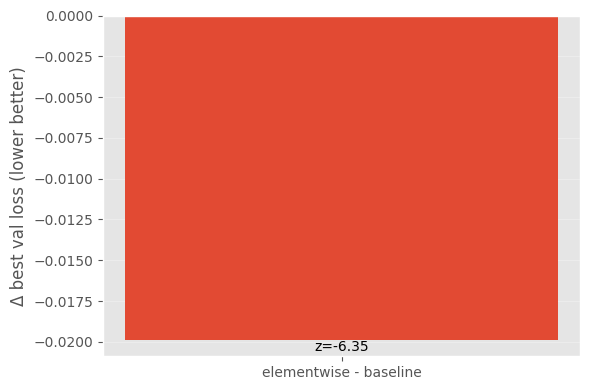

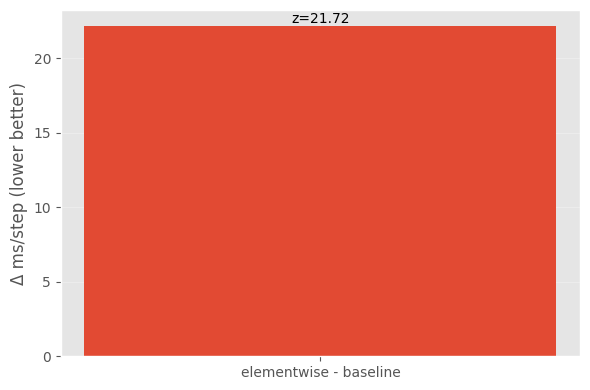

In [ ]:
# Aggregate comparison with deltas (elementwise vs baseline)
if not df.empty:
    agg = df.groupby('attn_gate').agg(
        runs=('run_id','count'),
        mean_best_val=('best_val_loss','mean'),
        std_best_val=('best_val_loss','std'),
        mean_final_val=('final_val_loss','mean'),
        mean_ms_step=('ms_per_step','mean'),
        std_ms_step=('ms_per_step','std'),
    ).reset_index()
    display(agg)
    if 'none' in agg['attn_gate'].values and 'elementwise' in agg['attn_gate'].values:
        base = agg.set_index('attn_gate').loc['none']
        elem = agg.set_index('attn_gate').loc['elementwise']
        # loss delta and z
        delta_loss = elem['mean_best_val'] - base['mean_best_val']
        std_loss = base['std_best_val'] if pd.notna(base['std_best_val']) and base['std_best_val']!=0 else float('nan')
        z_loss = delta_loss / std_loss if std_loss==std_loss and std_loss!=0 else float('nan')
        # ms/step delta and z (using baseline std)
        delta_ms = elem['mean_ms_step'] - base['mean_ms_step']
        std_ms = base['std_ms_step'] if pd.notna(base['std_ms_step']) and base['std_ms_step']!=0 else float('nan')
        z_ms = delta_ms / std_ms if std_ms==std_ms and std_ms!=0 else float('nan')

        fig, ax = plt.subplots(figsize=(6,4))
        ax.bar([0], [delta_loss])
        ax.set_xticks([0]); ax.set_xticklabels(['elementwise - baseline'])
        ax.set_ylabel('Δ best val loss (lower better)')
        ax.bar_label(ax.containers[0], labels=[f'z={z_loss:.2f}' if z_loss==z_loss else 'z=NA'])
        ax.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

        fig, ax = plt.subplots(figsize=(6,4))
        ax.bar([0], [delta_ms])
        ax.set_xticks([0]); ax.set_xticklabels(['elementwise - baseline'])
        ax.set_ylabel('Δ ms/step (lower better)')
        ax.bar_label(ax.containers[0], labels=[f'{z_ms:.2f}σ' if z_ms==z_ms else 'σ=NA'])
        ax.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()
    else:
        print('Baseline or elementwise missing; cannot compute deltas.')
else:
    print('No stage2.5 results found; ensure runs are logged.')


In [9]:
# Load curves from CSV or parse logs
curves = pd.DataFrame()
if CURVES_CSV.exists():
    curves = pd.read_csv(CURVES_CSV)
else:
    VAL_RE = re.compile(r"step:(\d+)/(\d+).*val_loss:([0-9.]+).*train_time:(\d+)ms")
    rows = []
    for path in LOG_DIR.glob('*.txt') if LOG_DIR.exists() else []:
        rid = path.stem
        cfg = df[df['run_id']==rid]
        if cfg.empty:
            continue
        cfg = cfg.iloc[0]
        with open(path) as f:
            for line in f:
                m = VAL_RE.search(line)
                if m:
                    step = int(m.group(1))
                    vloss = float(m.group(3))
                    t_ms = int(m.group(4))
                    rows.append({
                        'run_id': rid,
                        'step': step,
                        'val_loss': vloss,
                        'train_time_ms': t_ms,
                        'attn_gate': cfg['attn_gate'],
                        'learning_rate': cfg['learning_rate'],
                    })
    curves = pd.DataFrame(rows)
curves.head() if not curves.empty else print('No curves parsed.')

,run_id,step,val_loss,train_time_ms,attn_gate,learning_rate
0,d8ccd85e-ab0b-4251-bda0-b00f25577e14,0,16.0277,319,none,0.00468
1,d8ccd85e-ab0b-4251-bda0-b00f25577e14,125,4.9892,45565,none,0.00468
2,d8ccd85e-ab0b-4251-bda0-b00f25577e14,250,4.3575,95981,none,0.00468
3,d8ccd85e-ab0b-4251-bda0-b00f25577e14,375,4.0581,145269,none,0.00468
4,d8ccd85e-ab0b-4251-bda0-b00f25577e14,500,3.9104,195574,none,0.00468


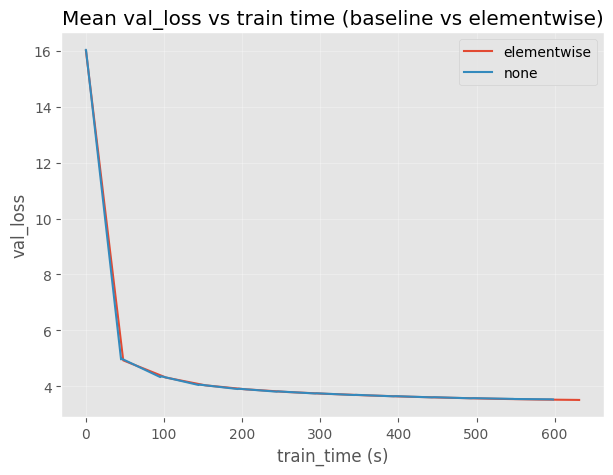

In [6]:
# Plot mean curves per attn_gate (averaged over runs)
if not curves.empty:
    fig, ax = plt.subplots(figsize=(7,5))
    for gate, sub in curves.groupby('attn_gate'):
        sub = sub.sort_values('train_time_ms')
        # average val_loss at each train_time_ms across runs (inner merge on time)
        mean_curve = sub.groupby('train_time_ms')['val_loss'].mean().reset_index()
        ax.plot(mean_curve['train_time_ms']/1000.0, mean_curve['val_loss'], label=gate)
    ax.set_xlabel('train_time (s)')
    ax.set_ylabel('val_loss')
    ax.set_title('Mean val_loss vs train time (baseline vs elementwise)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
else:
    print('No curves to plot.')


In [13]:
# Export curves (if parsed from logs or loaded)
if not curves.empty:
    export_path = CURVES_CSV
    export_path.parent.mkdir(parents=True, exist_ok=True)
    curves.to_csv(export_path, index=False)
    print(f"Saved curves to {export_path}")
else:
    print('curves is empty; nothing to export.')

Saved curves to /home/milos/dev/ese-3060-project/experiments/log_curves_stage2_5.csv
